# Visualizing MBTA Usage During the COVID-19 Pandemic

How do government actions affect the decisions people make? How much does fear of infection affect those decisions? We can examine these questions in the context of our personal mobility by looking at MBTA ridership through the pandemic.

## Data Sources

### Government Statements

An overview of Massachusetts declarations is available [here](https://www.mass.gov/info-details/covid-19-prevention-and-treatment). The [original emergency declaration](https://www.mass.gov/doc/march-23-2020-essential-services-and-revised-gatherings-order/download) from March 23 contains more detailed information.

### MBTA Usage

`data/MBTA_Gated_Station_Entries.json`

The MBTA publishes counts of entries at all gated subway, Silver Line and light rail stations [here](https://mbta-massdot.opendata.arcgis.com/datasets/mbta-gated-station-entries). The [API](https://services1.arcgis.com/ceiitspzDAHrdGO1/arcgis/rest/services/GSE/FeatureServer/0/query?outFields=*&where=1%3D1) currently provides data through March 31, 2020. Counts are binned to 30 minute intervals.

### Light Rail Stops

`data/light-rail-stops.json`

Each record in the usage dataset references a stop ID. The MBTA publishes separate datasets to map ID's to stop locations. [This dataset](https://mbta-massdot.opendata.arcgis.com/datasets/gtfs-mbta-systemwide?geometry=-72.893%2C41.475%2C-69.581%2C42.900&layer=0) contains locations of Subway and Light Rail stops in the MBTA system. It does not include Silver line stops. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import datetime
import collections

In [26]:
# Download MBTA usage data
start_date="2019-12-25 00:00:00"
download_path="data/MBTA_Gated_Station_Entries.json"

!cd download-mbta-usage/ && npm start "{start_date}" "../{download_path}"


> node@1.0.0 start /home/aball/dev/covid-analysis/download-mbta-usage
> node index.js "2019-12-25 00:00:00" "../data/MBTA_Gated_Station_Entries.json"

../data/MBTA_Gated_Station_Entries.json already exists


In [33]:
# Load station locations
with open('data/light-rail-stops.json') as f:
    station_json = json.loads(f.read())

stations = pd.json_normalize(station_json['features'])

,type,id,geometry.type,geometry.coordinates,properties.OBJECTID,properties.stop_id,properties.stop_code,properties.stop_name,properties.stop_desc,properties.platform_code,...,properties.Sidewalk_Condition,properties.Sidewalk_Material,properties.Current_Shelter,properties.Routes,properties.Municipality_1,properties.Neighborhood,properties.created_user,properties.created_date,properties.last_edited_user,properties.last_edited_date
64,Feature,475186,Point,"[-71.08617700040988, 42.36249099997762]",475186,place-knncl,None,Kendall/MIT,None,None,...,None,None,None,None,None,None,DOT_ADMIN,1587551553000,DOT_ADMIN,1587551553000


In [15]:
# Load usage data
def load_ticketing():
    with open('data/MBTA_Gated_Station_Entries.json') as f:
        return pd.json_normalize(json.load(f)).rename(columns=lambda col: col.split('attributes.')[1])

raw_ticketing = load_ticketing()
display(raw_ticketing)

,service_date,time_period,stop_id,station_name,route_or_line,gated_entries,ObjectId
0,1585627200000,(00:00:00),place-alfcl,Alewife,Red Line,2,1
1,1585627200000,(00:00:00),place-andrw,Andrew,Red Line,6,2
2,1585627200000,(00:00:00),place-aport,Airport,Blue Line,5,3
3,1585627200000,(00:00:00),place-asmnl,Ashmont,Red Line,4,4
4,1585627200000,(00:00:00),place-astao,Assembly,Orange Line,2,5
...,...,...,...,...,...,...,...
277120,1577250000000,(23:30:00),place-mlmnl,Malden Center,Orange Line,4,277183
277121,1577250000000,(23:30:00),place-mvbcl,Maverick,Blue Line,19,277185
277122,1577250000000,(23:30:00),place-north,North Station,Green Line,5,277186
277123,1577250000000,(23:30:00),place-north,North Station,Orange Line,11,277188


In [27]:
# Convert service_date and time_period to actual start times for each binned 30-minute period

one_day = datetime.timedelta(days=1)
def compute_start_time(row):
    date = row['service_date']
    time = row['time_period'].time()
    return pd.Timestamp.combine(date if time.hour >= 3 else date + one_day, time)

datetime_fields = ['service_date', 'time_period']

ticketing = raw_ticketing
ticketing['service_date'] = pd.to_datetime(ticketing['service_date'], unit='ms')
ticketing['time_period'] = pd.to_datetime(ticketing['time_period'], format="(%H:%M:%S)")
ticketing['window_start_time'] = ticketing.apply(compute_start_time, axis='columns')

display(ticketing)

,service_date,time_period,stop_id,station_name,route_or_line,gated_entries,ObjectId,window_start_time
0,2020-03-31 04:00:00,1900-01-01 00:00:00,place-alfcl,Alewife,Red Line,2,1,2020-04-01 00:00:00
1,2020-03-31 04:00:00,1900-01-01 00:00:00,place-andrw,Andrew,Red Line,6,2,2020-04-01 00:00:00
2,2020-03-31 04:00:00,1900-01-01 00:00:00,place-aport,Airport,Blue Line,5,3,2020-04-01 00:00:00
3,2020-03-31 04:00:00,1900-01-01 00:00:00,place-asmnl,Ashmont,Red Line,4,4,2020-04-01 00:00:00
4,2020-03-31 04:00:00,1900-01-01 00:00:00,place-astao,Assembly,Orange Line,2,5,2020-04-01 00:00:00
...,...,...,...,...,...,...,...,...
277120,2019-12-25 05:00:00,1900-01-01 23:30:00,place-mlmnl,Malden Center,Orange Line,4,277183,2019-12-25 23:30:00
277121,2019-12-25 05:00:00,1900-01-01 23:30:00,place-mvbcl,Maverick,Blue Line,19,277185,2019-12-25 23:30:00
277122,2019-12-25 05:00:00,1900-01-01 23:30:00,place-north,North Station,Green Line,5,277186,2019-12-25 23:30:00
277123,2019-12-25 05:00:00,1900-01-01 23:30:00,place-north,North Station,Orange Line,11,277188,2019-12-25 23:30:00


In [13]:
ticketing_with_locations = pd.merge(left=stations, right=ticketing, left_on='properties.stop_id', right_on='stop_id', validate='one_to_many')

Text(0.5, 0, 'Midnight on Date')

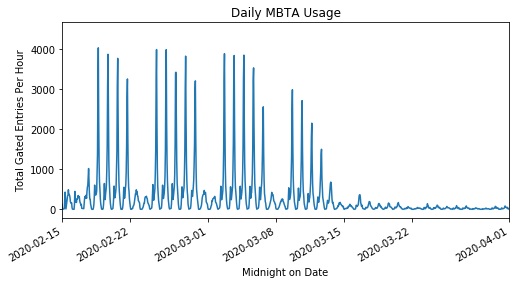

In [54]:
stops = ticketing['stop_id'] == 'place-knncl'
ridership_by_time = ticketing[stops].set_index('window_start_time').groupby(by=lambda time: time.floor('H')).agg(total_entries=pd.NamedAgg(column='gated_entries', aggfunc='sum'))
ridership_by_time.plot(figsize=[8, 4])

plt.gca().get_legend().remove()
plt.title("Daily MBTA Usage")
plt.xlim(datetime.date(2020, 2, 15), datetime.date(2020, 4, 1))
plt.ylabel("Total Gated Entries Per Hour")
plt.xlabel("Midnight on Date")